In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans

In [3]:
train = pd.read_excel("../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx", header=[0,1])
train.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in train.columns.values]

In [4]:
#mySeries 만들기 - 수위 E데이터
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler

cnts = train['홍수사상번호'].value_counts()
tmp = pd.Series([0], index=[0])
cnts = cnts.append(tmp)
cnts = cnts.sort_index().cumsum()


mySeries=[]
for i in range(1,27):
    flood = train['데이터집단 1_수위(E지역)'][cnts[i-1]:cnts[i]]  # 홍수사상번호별 유입량 Series
    mySeries.append(flood)
    
myArrays=[]
for i in range(26):
    tmp = mySeries[i].to_numpy()
    myArrays.append(tmp)

X = to_time_series_dataset([myArrays[i] for i in range(26)])
X_normal = TimeSeriesScalerMeanVariance().fit_transform(X)

In [5]:
train.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1_유역평균강수,데이터집단 1_강우(A지역),데이터집단 1_강우(B지역),데이터집단 1_강우(C지역),...,데이터 집단 5_강우(D지역),데이터 집단 5_수위(E지역),데이터 집단 5_수위(D지역),데이터 집단 6_유역평균강수,데이터 집단 6_강우(A지역),데이터 집단 6_강우(B지역),데이터 집단 6_강우(C지역),데이터 집단 6_강우(D지역),데이터 집단 6_수위(E지역),데이터 집단 6_수위(D지역)
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [6]:
cluster_k = 0
# 알맞은 k 정하기 - 실루엣 점수 사용
from tslearn.clustering import silhouette_score
labels = np.random.randint(2, size=26)
y = silhouette_score(X_normal, labels, metric="softdtw")
y

0.005783510828591142

k = 3 일때 클러스터 결과

384.685 --> 26.801 --> 27.061 --> 26.773 --> 26.934 --> 26.779 --> 27.060 --> 26.733 --> 26.899 --> 26.740 --> 27.031 --> 26.703 --> 26.856 --> 26.732 --> 26.849 --> 26.740 --> 26.843 --> 26.742 --> 26.940 --> 26.716 --> 26.831 --> 26.734 --> 26.936 --> 26.695 --> 26.829 --> 26.694 --> 26.947 --> 26.657 --> 26.792 --> 26.675 --> 26.780 --> 26.675 --> 26.767 --> 26.675 --> 26.757 --> 26.676 --> 26.751 --> 26.673 --> 26.747 --> 26.668 --> 26.810 --> 26.635 --> 26.731 --> 26.636 --> 26.785 --> 26.603 --> 26.693 --> 26.615 --> 26.749 --> 26.589 --> 


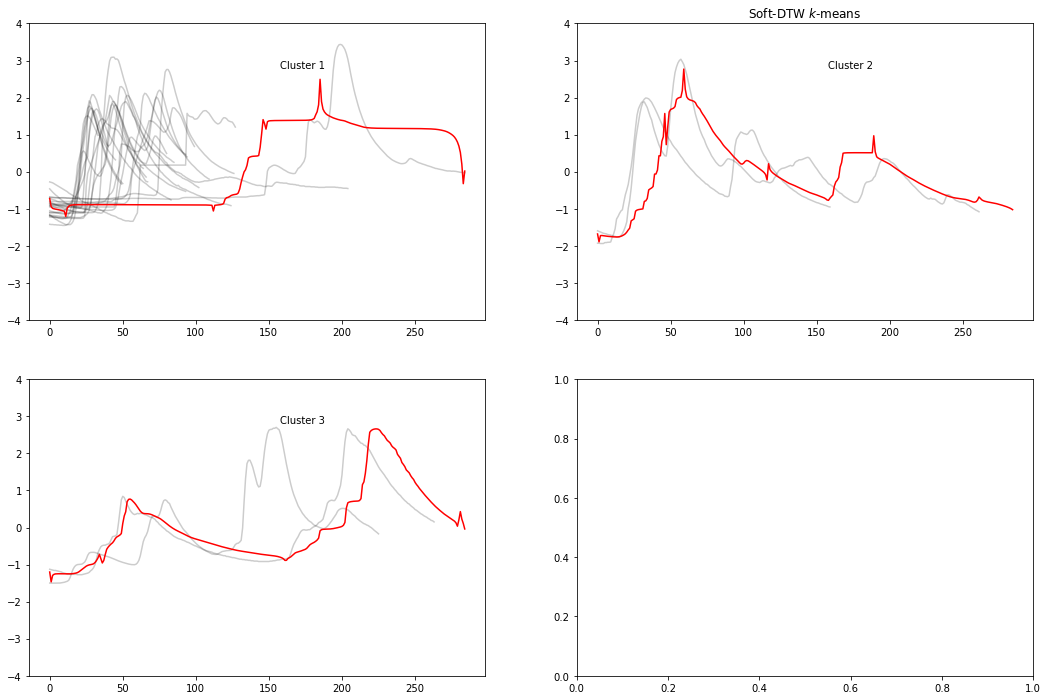

In [7]:
import matplotlib.pyplot as plt
cluster_k = 3 #K=3
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,2, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

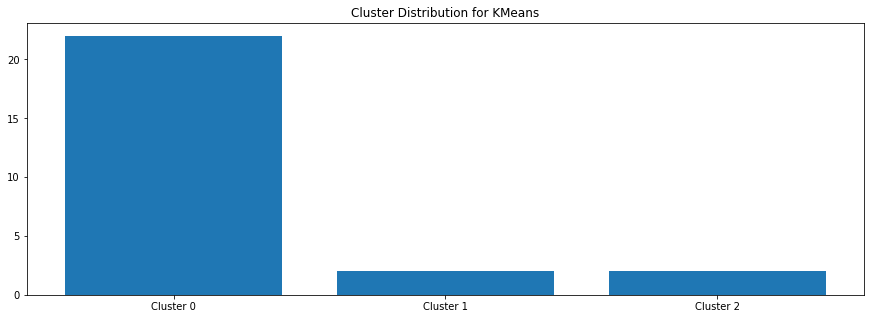

In [8]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [9]:
labels3 =[]
labels3 = y_pred
df = pd.DataFrame(labels3, columns = ['3_수위(E지역)'])
all_scores = np.zeros((7,))
all_scores[0] = silhouette_score(X_normal, labels3, metric="softdtw")

k = 4 일때 클러스터 결과

344.860 --> 14.854 --> 13.691 --> 13.609 --> 13.659 --> 13.633 --> 13.661 --> 13.637 --> 13.662 --> 13.642 --> 13.661 --> 13.639 --> 13.658 --> 13.637 --> 13.654 --> 13.633 --> 13.650 --> 13.630 --> 13.646 --> 13.626 --> 13.642 --> 13.623 --> 13.637 --> 13.619 --> 13.634 --> 13.616 --> 13.630 --> 13.613 --> 13.626 --> 13.610 --> 13.623 --> 13.606 --> 13.619 --> 13.603 --> 13.616 --> 13.600 --> 13.613 --> 13.596 --> 13.610 --> 13.593 --> 13.606 --> 13.590 --> 13.603 --> 13.587 --> 13.600 --> 13.584 --> 13.597 --> 13.582 --> 13.594 --> 13.580 --> 


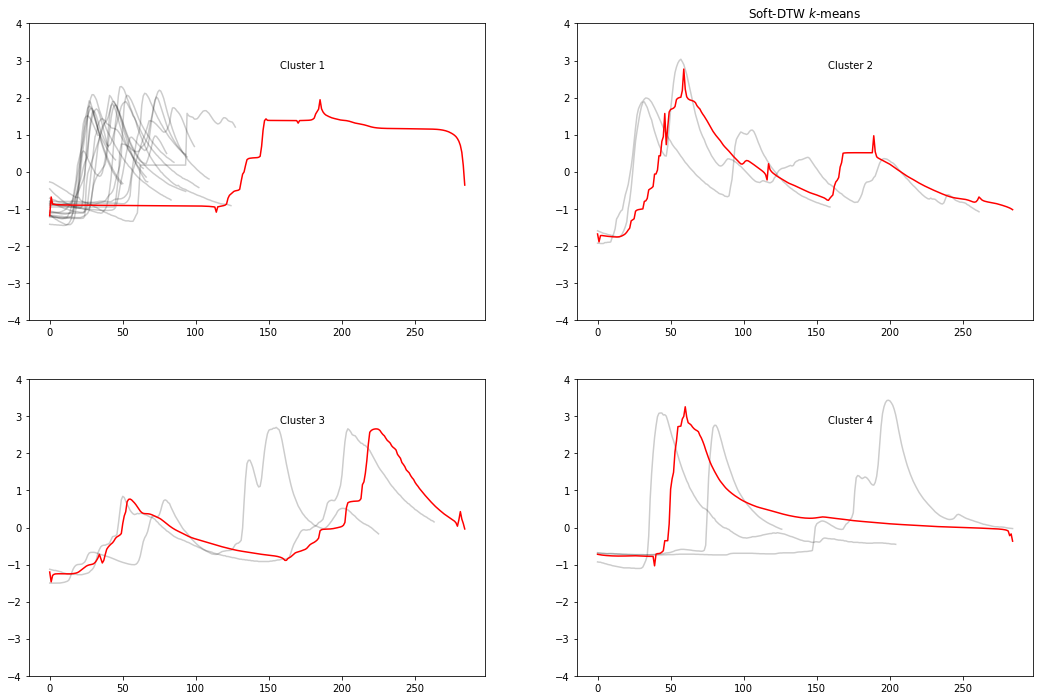

In [10]:
import matplotlib.pyplot as plt
cluster_k = 4 #K=4
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,2, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

In [11]:
cluster_c

[22, 2, 2]

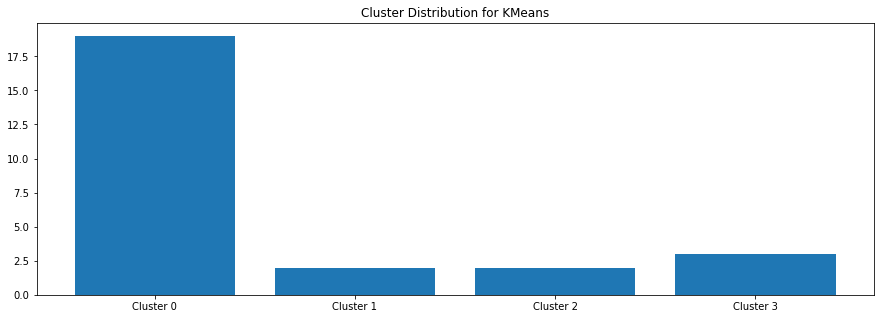

In [12]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [13]:
labels4 =[]
labels4 = y_pred
df['4_수위(E지역)'] = labels4
all_scores[1] = silhouette_score(X_normal, labels4, metric="softdtw")

k = 5 일때 클러스터 결과

113.699 --> 6.025 --> 3.115 --> 2.707 --> 2.687 --> 2.708 --> 2.693 --> 2.712 --> 2.698 --> 2.707 --> 2.701 --> 2.709 --> 2.702 --> 2.710 --> 2.703 --> 2.707 --> 2.702 --> 2.709 --> 2.704 --> 2.708 --> 2.700 --> 2.707 --> 2.700 --> 2.707 --> 2.701 --> 2.706 --> 2.701 --> 2.707 --> 2.701 --> 2.705 --> 2.700 --> 2.709 --> 2.701 --> 2.711 --> 2.702 --> 2.715 --> 2.701 --> 2.713 --> 2.703 --> 2.698 --> 2.702 --> 2.700 --> 2.703 --> 2.701 --> 2.707 --> 2.703 --> 2.707 --> 2.700 --> 2.710 --> 2.699 --> 


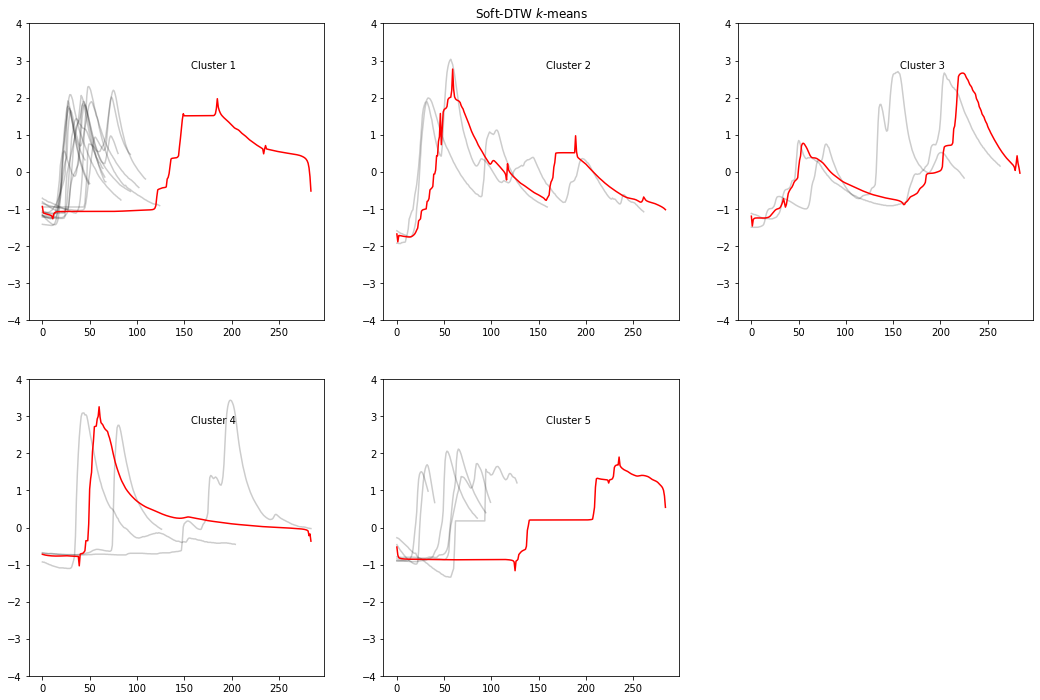

In [14]:
import matplotlib.pyplot as plt
cluster_k = 5 #K=5
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,3, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

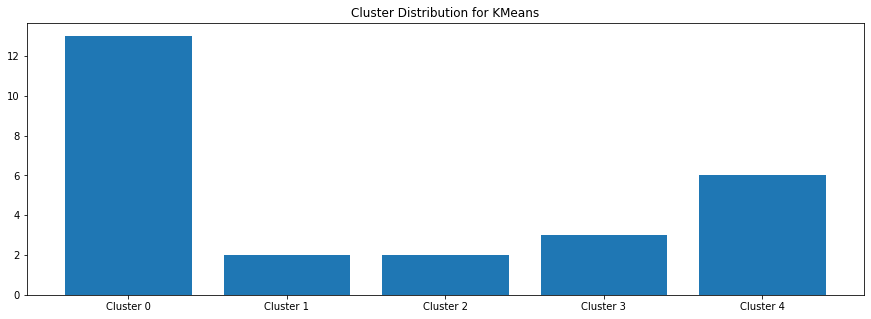

In [15]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [16]:
labels5 =[]
labels5 = y_pred
df['5_수위(E지역)'] = labels5
all_scores[2] = silhouette_score(X_normal, labels5, metric="softdtw")

k = 6 일때 클러스터 결과

83.310 --> 6.661 --> 3.752 --> 3.344 --> 3.325 --> 3.346 --> 3.331 --> 3.350 --> 3.336 --> 3.345 --> 3.339 --> 3.347 --> 3.340 --> 3.348 --> 3.341 --> 3.345 --> 3.340 --> 3.347 --> 3.342 --> 3.347 --> 3.339 --> 3.346 --> 3.339 --> 3.345 --> 3.339 --> 3.344 --> 3.339 --> 3.346 --> 3.339 --> 3.343 --> 3.339 --> 3.348 --> 3.340 --> 3.350 --> 3.340 --> 3.353 --> 3.340 --> 3.351 --> 3.341 --> 3.336 --> 3.341 --> 3.338 --> 3.341 --> 3.340 --> 3.345 --> 3.342 --> 3.346 --> 3.339 --> 3.348 --> 3.338 --> 


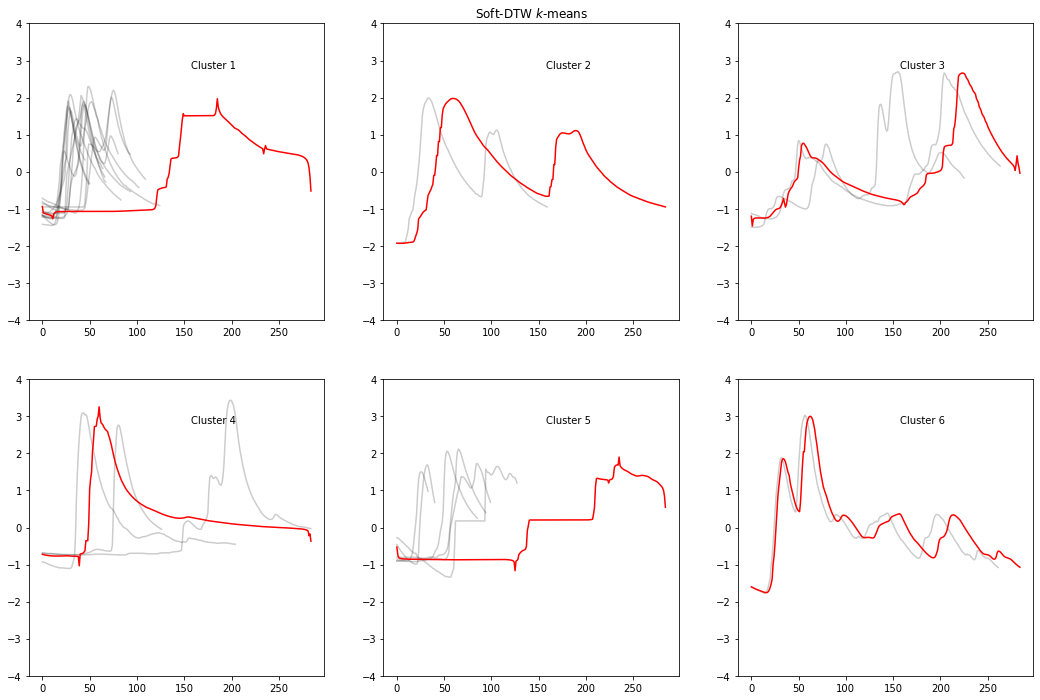

In [17]:
import matplotlib.pyplot as plt
cluster_k = 6 #K=6
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,3, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

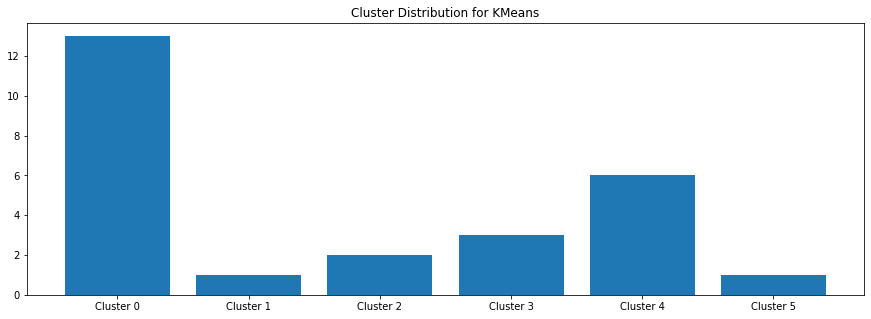

In [18]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [19]:
labels6 =[]
labels6 = y_pred
df['6_수위(E지역)'] = labels6
all_scores[3] = silhouette_score(X_normal, labels6, metric="softdtw")

k = 7 일때 클러스터 결과

59.057 --> 5.925 --> 4.771 --> 4.362 --> 4.347 --> 4.366 --> 4.356 --> 4.377 --> 4.356 --> 4.365 --> 4.349 --> 4.370 --> 4.354 --> 4.384 --> 4.358 --> 4.369 --> 4.355 --> 4.399 --> 4.362 --> 4.384 --> 4.342 --> 4.334 --> 4.343 --> 4.339 --> 4.344 --> 4.338 --> 4.343 --> 4.340 --> 4.345 --> 4.341 --> 4.348 --> 4.342 --> 4.350 --> 4.342 --> 4.354 --> 4.343 --> 4.357 --> 4.344 --> 4.329 --> 4.344 --> 4.338 --> 4.348 --> 4.335 --> 4.351 --> 4.339 --> 4.364 --> 4.340 --> 4.350 --> 4.340 --> 4.367 --> 


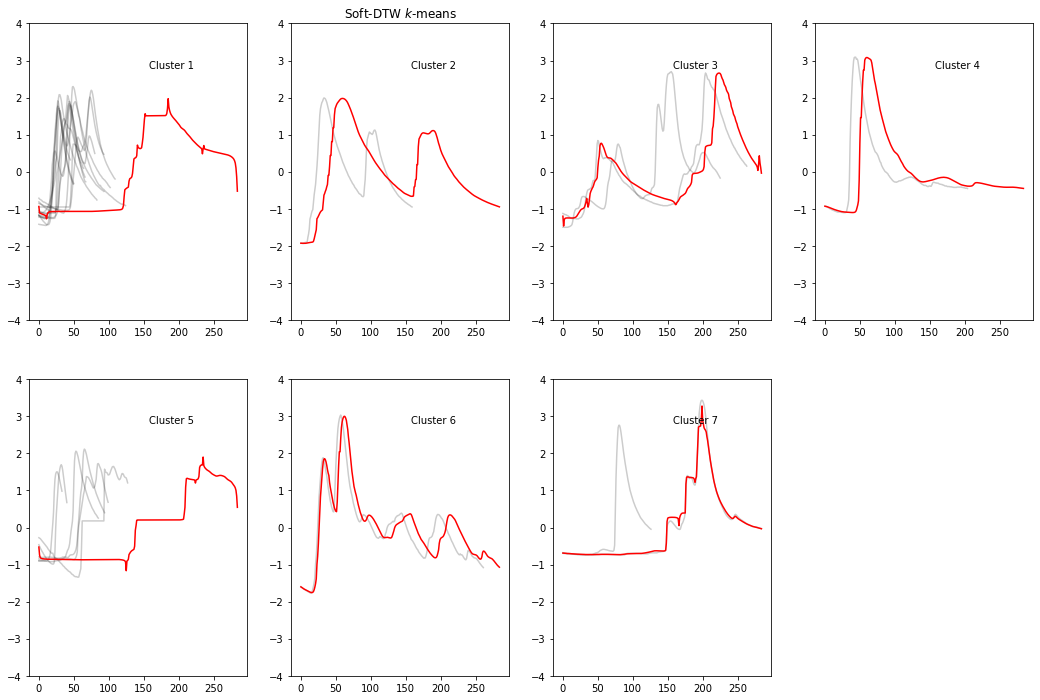

In [20]:
import matplotlib.pyplot as plt
cluster_k = 7 #K=7
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,4, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

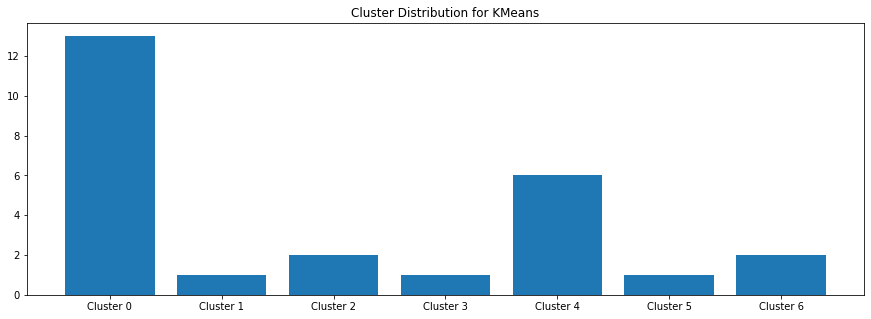

In [21]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [22]:
labels7 =[]
labels7 = y_pred
df['7_수위(E지역)'] = labels7
all_scores[4] = silhouette_score(X_normal, labels7, metric="softdtw")

k = 8 일때 클러스터 결과

43.548 --> 3.187 --> 2.675 --> 2.452 --> 2.452 --> 2.455 --> 2.455 --> 2.461 --> 2.453 --> 2.453 --> 2.454 --> 2.453 --> 2.454 --> 2.454 --> 2.454 --> 2.454 --> 2.455 --> 2.454 --> 2.456 --> 2.454 --> 2.452 --> 2.454 --> 2.453 --> 2.453 --> 2.454 --> 2.454 --> 2.453 --> 2.454 --> 2.453 --> 2.454 --> 2.453 --> 2.454 --> 2.454 --> 2.455 --> 2.454 --> 2.455 --> 2.454 --> 2.455 --> 2.454 --> 2.455 --> 2.455 --> 2.456 --> 2.455 --> 2.456 --> 2.455 --> 2.458 --> 2.453 --> 2.454 --> 2.454 --> 2.454 --> 


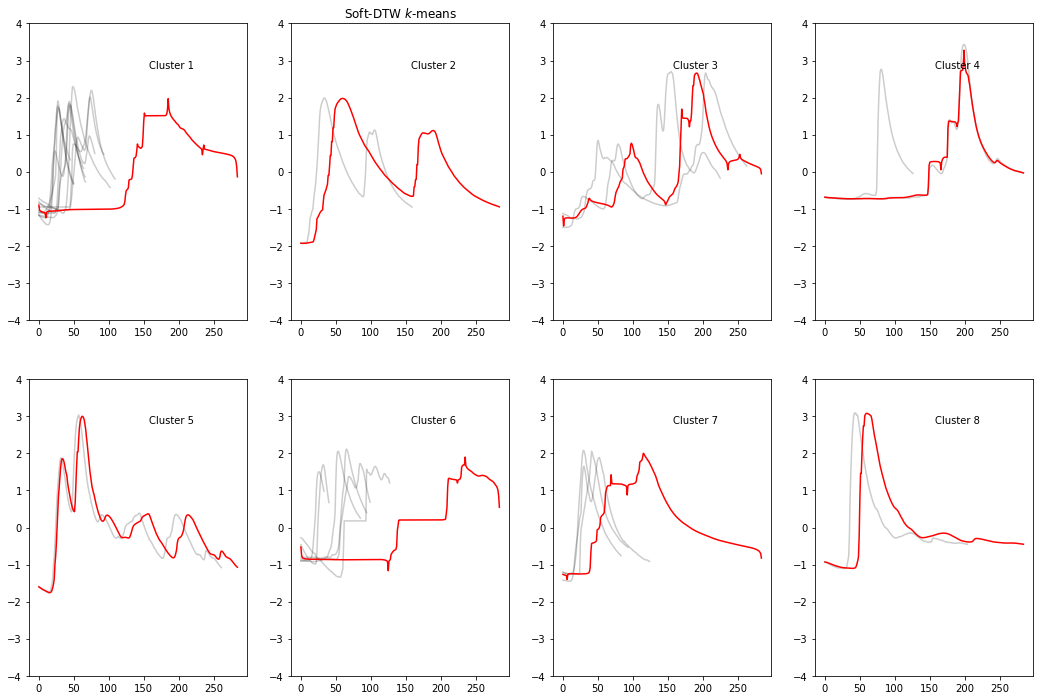

In [23]:
import matplotlib.pyplot as plt
cluster_k = 8 #K=8
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,4, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

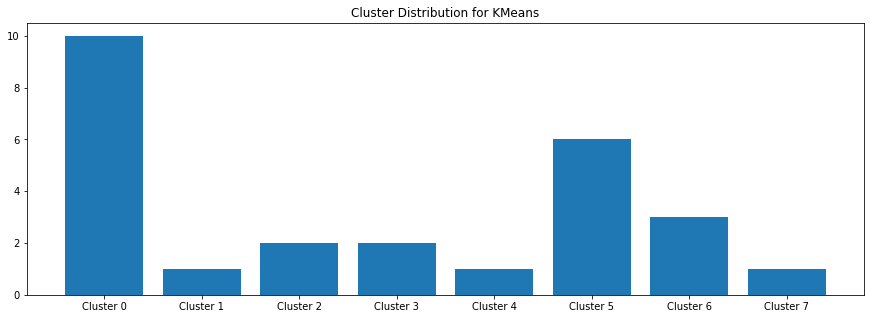

In [24]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [25]:
labels8 =[]
labels8 = y_pred
df['8_수위(E지역)'] = labels8
all_scores[5] = silhouette_score(X_normal, labels8, metric="softdtw")

k = 9 일때 클러스터 결과

13.956 --> 3.005 --> 3.011 --> 3.002 --> 3.007 --> 2.980 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.978 --> 2.979 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.979 --> 2.980 --> 2.978 --> 2.980 --> 2.978 --> 2.980 --> 2.978 --> 2.980 --> 2.978 --> 2.979 --> 2.978 --> 2.979 --> 2.978 --> 2.979 --> 2.977 --> 2.979 --> 2.977 --> 2.979 --> 2.977 --> 2.979 --> 2.977 --> 2.979 --> 2.977 --> 2.979 --> 2.977 --> 2.979 --> 


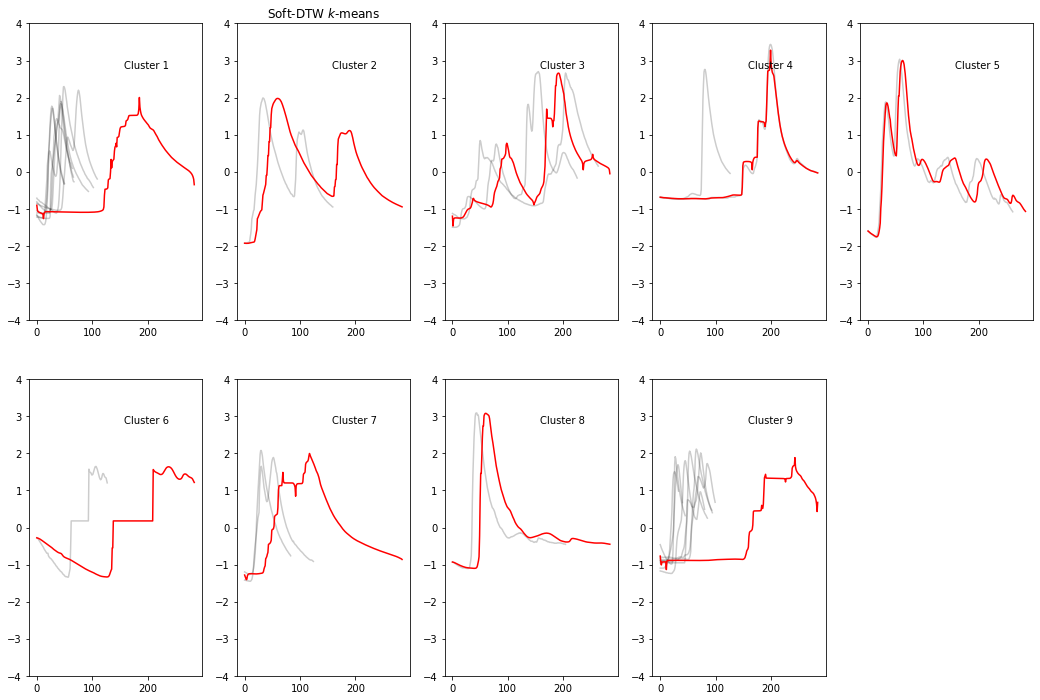

In [26]:
import matplotlib.pyplot as plt
cluster_k = 9 #K=9
sdtw_km = TimeSeriesKMeans(n_clusters=cluster_k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=0)
y_pred = sdtw_km.fit_predict(X_normal)

plt.subplots(2,2,figsize=(18,12))
for yi in range(cluster_k):
    plt.subplot(2,5, 1+yi)
    for xx in X_normal[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

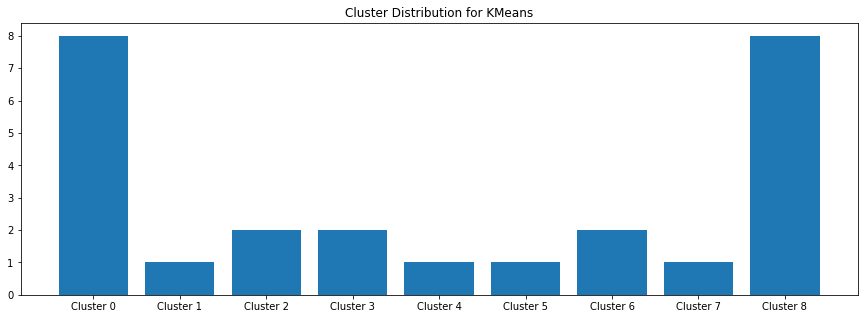

In [27]:
cluster_count = cluster_k
cluster_c = [len(y_pred[y_pred==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [28]:
labels9 =[]
labels9 = y_pred
df['9_수위(E지역)'] = labels9
all_scores[6] = silhouette_score(X_normal, labels9, metric="softdtw")

실루엣 점수를 통한 최적의 K 측정

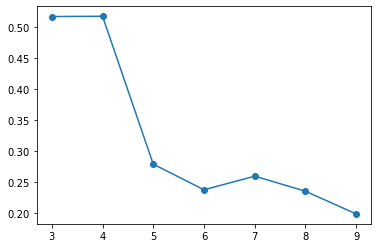

In [29]:
k_range = np.arange(3, 10, 1)
plt.plot(k_range, all_scores, marker='o')
plt.show()

실루엣 점수는 1에서 -1까지의 수치를 가지는데, +1에 가까우면 자신이 클러스터 안에 잘 속해있고 다른 클러스터와는 멀리 떨어져 있다는 뜻이다. 0과 가까울 수록 클러스터의 경계에 데이터가 위치해 있다는 뜻이고, -1에 가까우면 샘플이 잘못된 클러스터에 할당되었다는 뜻이다.

위에 따라 k=3 또는 k=4일때 비교적 클러스터링이 잘 되었다는 것을 알 수 있다.

In [30]:
k3_column = pd.DataFrame(train['홍수사상번호'], columns = ['홍수사상번호'])
k3_column["군집 결과"] = np.nan
for i in range(len(k3_column)):
    tmp = k3_column['홍수사상번호'][i]
    tmp = tmp - 1
    k3_column['군집 결과'][i] = labels3[tmp]
k3_column_final = pd.get_dummies(k3_column['군집 결과'])
k3_column_final
#k3_column_final 이용

,0.0,1.0,2.0
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
3046,0,1,0
3047,0,1,0
3048,0,1,0
3049,0,1,0


In [34]:
k4_column = pd.DataFrame(train['홍수사상번호'], columns = ['홍수사상번호'])
k4_column["군집 결과"] = np.nan
for i in range(len(k4_column)):
    tmp = k4_column['홍수사상번호'][i]
    tmp = tmp - 1
    k4_column['군집 결과'][i] = labels4[tmp]
k4_column_final = pd.get_dummies(k4_column['군집 결과'])
k4_column_final
#k4_column_final 이용

,0.0,1.0,2.0,3.0
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
3046,0,1,0,0
3047,0,1,0,0
3048,0,1,0,0
3049,0,1,0,0


In [35]:
k5_column = pd.DataFrame(train['홍수사상번호'], columns = ['홍수사상번호'])
k5_column["군집 결과"] = np.nan
for i in range(len(k5_column)):
    tmp = k5_column['홍수사상번호'][i]
    tmp = tmp - 1
    k5_column['군집 결과'][i] = labels5[tmp]
k5_column_final = pd.get_dummies(k5_column['군집 결과'])
k5_column_final
#k5_column_final 이용

,0.0,1.0,2.0,3.0,4.0
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
3046,0,1,0,0,0
3047,0,1,0,0,0
3048,0,1,0,0,0
3049,0,1,0,0,0


In [36]:
k6_column = pd.DataFrame(train['홍수사상번호'], columns = ['홍수사상번호'])
k6_column["군집 결과"] = np.nan
for i in range(len(k6_column)):
    tmp = k6_column['홍수사상번호'][i]
    tmp = tmp - 1
    k6_column['군집 결과'][i] = labels6[tmp]
k6_column_final = pd.get_dummies(k6_column['군집 결과'])
k6_column_final
#k6_column_final 이용

,0.0,1.0,2.0,3.0,4.0,5.0
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
3046,0,1,0,0,0,0
3047,0,1,0,0,0,0
3048,0,1,0,0,0,0
3049,0,1,0,0,0,0


In [44]:
k3_column_final.to_csv('../data/clustering/3_clustering_result.csv')
k4_column_final.to_csv('../data/clustering/4_clustering_result.csv')
k5_column_final.to_csv('../data/clustering/5_clustering_result.csv')
k6_column_final.to_csv('../data/clustering/6_clustering_result.csv')

## 결과 보기

In [38]:
data = pd.read_excel("../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx", header=[0,1])
data.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data.columns.values]

In [45]:
k3_column_final = pd.read_csv('../data/clustering/3_clustering_result.csv', index_col=0)
k4_column_final = pd.read_csv('../data/clustering/4_clustering_result.csv', index_col=0)
k5_column_final = pd.read_csv('../data/clustering/5_clustering_result.csv', index_col=0)
k6_column_final = pd.read_csv('../data/clustering/6_clustering_result.csv', index_col=0)

군집 : k1 num_list : [ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 21 22 23 24 25]


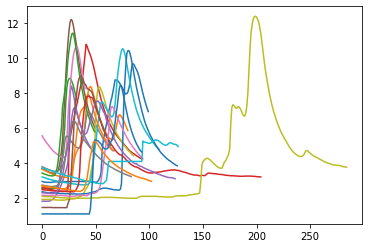

군집 : k2 num_list : [15 26]


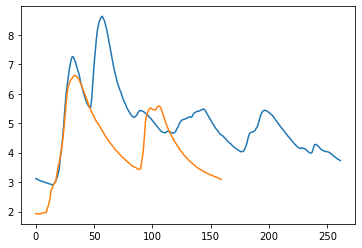

군집 : k3 num_list : [ 1 20]


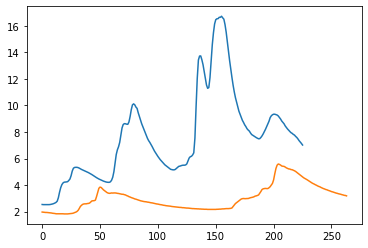

In [40]:
k3_column_final

cluster_list = ['k1', 'k2', 'k3']
data[cluster_list] = k3_column_final

for k in cluster_list:
    data_k = data[data[k] == 1]
    num_list = data_k.홍수사상번호.unique()
    print(f"군집 : {k} num_list : {num_list}")
    for n in num_list:
        data_num = data_k[data_k.홍수사상번호 == n]
        plt.plot(data_num['데이터집단 1_수위(E지역)'].values)
    plt.show()

군집 : k1 num_list : [ 2  3  4  5  6  7  8  9 10 11 13 14 17 18 19 21 23 24 25]


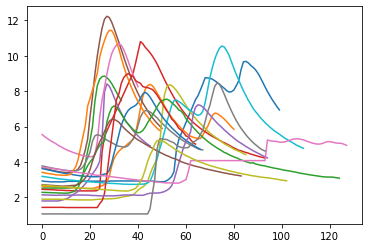

군집 : k2 num_list : [15 26]


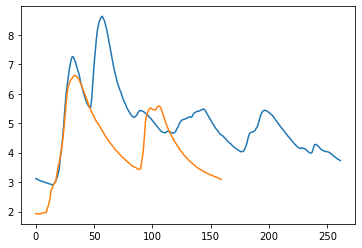

군집 : k3 num_list : [ 1 20]


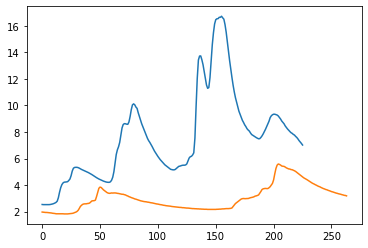

군집 : k4 num_list : [12 16 22]


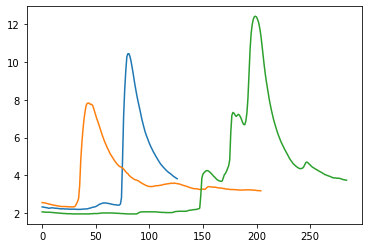

In [41]:
k4_column_final

cluster_list = ['k1', 'k2', 'k3', 'k4']
data[cluster_list] = k4_column_final

for k in cluster_list:
    data_k = data[data[k] == 1]
    num_list = data_k.홍수사상번호.unique()
    print(f"군집 : {k} num_list : {num_list}")
    for n in num_list:
        data_num = data_k[data_k.홍수사상번호 == n]
        plt.plot(data_num['데이터집단 1_수위(E지역)'].values)
    plt.show()

군집 : k1 num_list : [ 3  5  6  7  9 11 13 14 17 18 21 24 25]


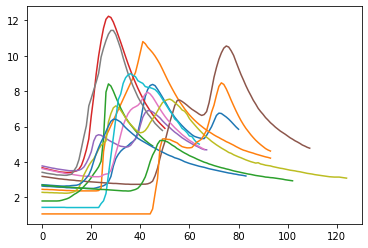

군집 : k2 num_list : [15 26]


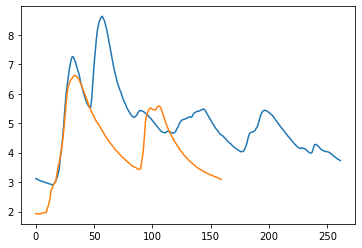

군집 : k3 num_list : [ 1 20]


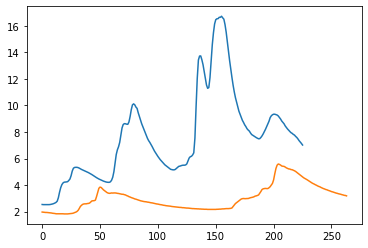

군집 : k4 num_list : [12 16 22]


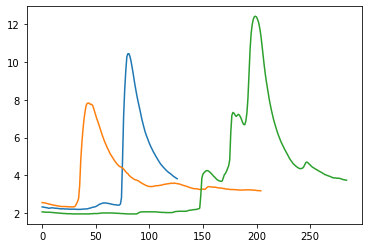

군집 : k5 num_list : [ 2  4  8 10 19 23]


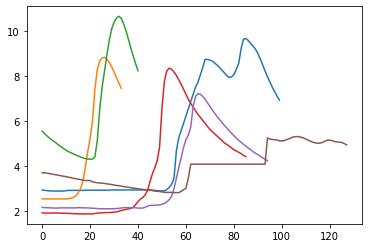

In [42]:
k5_column_final

cluster_list = ['k1', 'k2', 'k3', 'k4', 'k5']
data[cluster_list] = k5_column_final

for k in cluster_list:
    data_k = data[data[k] == 1]
    num_list = data_k.홍수사상번호.unique()
    print(f"군집 : {k} num_list : {num_list}")
    for n in num_list:
        data_num = data_k[data_k.홍수사상번호 == n]
        plt.plot(data_num['데이터집단 1_수위(E지역)'].values)
    plt.show()

군집 : k1 num_list : [ 3  5  6  7  9 11 13 14 17 18 21 24 25]


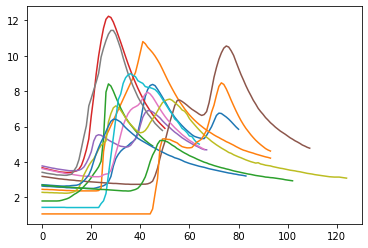

군집 : k2 num_list : [26]


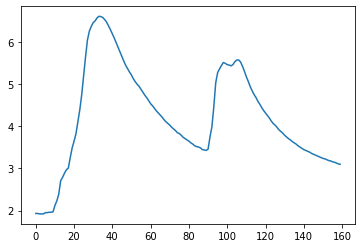

군집 : k3 num_list : [ 1 20]


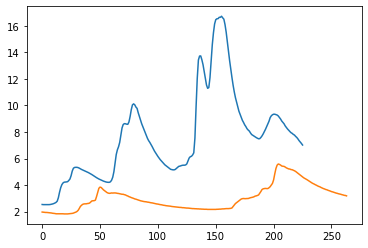

군집 : k4 num_list : [12 16 22]


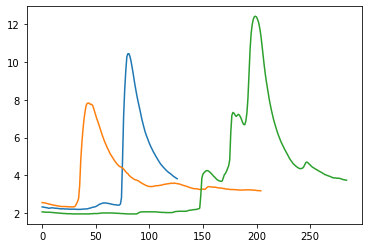

군집 : k5 num_list : [ 2  4  8 10 19 23]


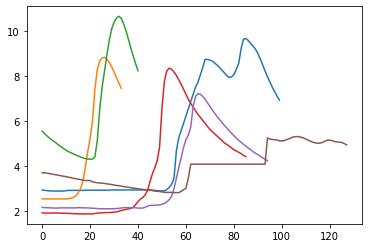

군집 : k6 num_list : [15]


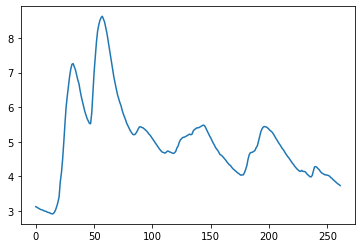

In [43]:
k6_column_final

cluster_list = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6']
data[cluster_list] = k6_column_final

for k in cluster_list:
    data_k = data[data[k] == 1]
    num_list = data_k.홍수사상번호.unique()
    print(f"군집 : {k} num_list : {num_list}")
    for n in num_list:
        data_num = data_k[data_k.홍수사상번호 == n]
        plt.plot(data_num['데이터집단 1_수위(E지역)'].values)
    plt.show()